In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from growth.sweep.sweep import Sweep
from clones.validation.sweep import SweepBenchmark
%matplotlib inline

In [2]:
ls ../synthetic/

Sweep_181201_191409/          Sweep_181201_191516_twolevel/
Sweep_181201_191516/          Sweep_181201_191521/
Sweep_181201_191516_katz/     build_sweep.py
Sweep_181201_191516_new/


# load sweep results

In [3]:
sweep_path = '../synthetic/Sweep_181201_191516_katz/'
sweep = Sweep.load(sweep_path)
sweep

1 x 16 sweep, 4 recombination generations

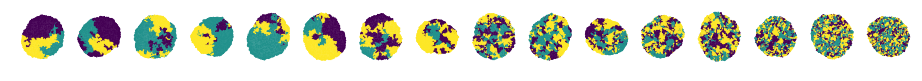

In [4]:
# plot single replicate for each batch
fig = sweep.plot_culture_grid(replicate_id=0, s=2)

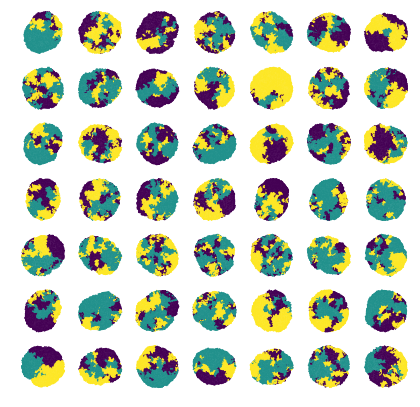

In [5]:
# plot all replicates for a single batch
fig = sweep.batches[0, 4].plot_culture_grid()

# load benchmarking results

In [5]:
benchmark = SweepBenchmark.load(sweep_path)

Results not compiled. Compile now?y


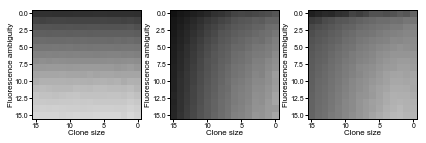

In [6]:
fig = benchmark.results.plot_absolute_error(log=True)

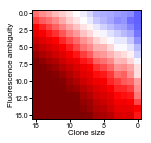

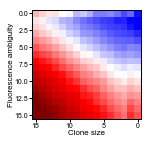

In [9]:
fig = benchmark.results.plot_relative_error()
fig = benchmark.results.plot_relative_error(method='katz', reference_method='simple')

In [33]:
batch_id, scale_id = 0, 2
batch_benchmark = benchmark.load_benchmark(batch_id, scale_id)

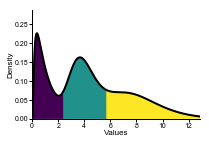

In [34]:
batch_benchmark.classifier.plot_pdf()

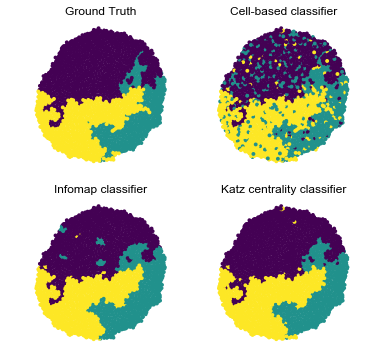

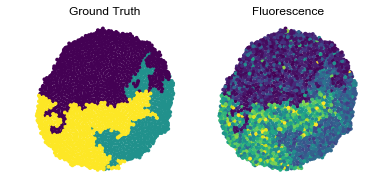

In [35]:
simulation_benchmark = batch_benchmark.benchmark_simulation(0)
simulation_benchmark.show_classifiers(s=15)
simulation_benchmark.show_measurements(s=15)

In [36]:
print('Simple: {:0.3f}'.format(simulation_benchmark.scores['simple'].MAE))
print('Community: {:0.3f}'.format(simulation_benchmark.scores['community'].MAE))
print('Katz: {:0.3f}'.format(simulation_benchmark.scores['katz'].MAE))

Simple: 0.079
Community: 0.031
Katz: 0.018


In [95]:
graph = simulation_benchmark.annotator.graph

In [142]:
cell_classifier = simulation_benchmark.annotator.cell_classifier

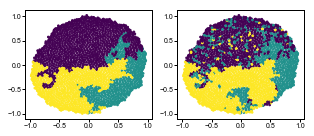

In [181]:
f = _build_pagerank_classifier(graph, cell_classifier, alpha=1.4)
labels = f(graph.df.index.values)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(5, 2))
ax0.scatter(*simulation_benchmark.xy.T, c=graph.df.ground, s=3)
ax1.scatter(*simulation_benchmark.xy.T, c=labels, s=3)

In [175]:
import networkx as nx

def _build_classifier(graph, cell_classifier, alpha=0.9):
    """
    Construct classifier baed on the maximum Katz centrality of posterior distributions applied to undirected edges weighted by node similarity.

    Args:

        graph (Graph) - graph connecting adjacent cells

        cell_classifier (BayesianClassifier) - labels individual cells

        alpha (float) - attenuation factor

    Returns:

        genotypes_dict (dict) - maps measurement index to genotype

    """

    # build undirected graph weighted by node similarity
    G = graph.get_networkx()

    # evaluate posterior genotype distribution for each node
    posterior = cell_classifier.evaluate_posterior(graph.df.loc[list(G.nodes)])

    # compile normalized adjacency matrix
    adjacency = nx.to_numpy_array(G)
    adjacency /= adjacency.sum(axis=0)

    # evaluate centrality
    n = np.array(adjacency).shape[0]
    centrality = np.linalg.solve(np.eye(n, n)-(alpha*adjacency), posterior)

    # return genotype mapping
    index_to_genotype = dict(zip(list(G.nodes), centrality.argmax(axis=1)))

    return np.vectorize(index_to_genotype.get)


def _build_pagerank_classifier(graph, cell_classifier, alpha=0.9):
    """
    Construct classifier baed on the maximum Katz centrality of posterior distributions applied to undirected edges weighted by node similarity.

    Args:

        graph (Graph) - graph connecting adjacent cells

        cell_classifier (BayesianClassifier) - labels individual cells

        alpha (float) - attenuation factor

    Returns:

        genotypes_dict (dict) - maps measurement index to genotype

    """

    # build undirected graph weighted by node similarity
    G = graph.get_networkx()

    # evaluate posterior genotype distribution for each node
    posterior = cell_classifier.evaluate_posterior(graph.df.loc[list(G.nodes)])

    # compile normalized adjacency matrix
    adjacency = nx.to_numpy_array(G)
    #adjacency /= adjacency.sum(axis=0)

    # evaluate centrality
    n = np.array(adjacency).shape[0]
    degrees = np.vectorize(G.degree.__getitem__)(G.nodes)
    matrix = np.eye(n, n)-(alpha*np.dot(adjacency, np.linalg.inv(np.diag(degrees))))
    centrality = np.linalg.solve(matrix, posterior)

    # return genotype mapping
    index_to_genotype = dict(zip(list(G.nodes), centrality.argmax(axis=1)))

    return np.vectorize(index_to_genotype.get)

In [151]:
# build undirected graph weighted by node similarity
G = graph.get_networkx()


In [154]:
# compile normalized adjacency matrix
adjacency = nx.to_numpy_array(G)
normalized_adjacency = adjacency / adjacency.sum(axis=0)

# evaluate centrality
n = np.array(adjacency).shape[0]
degrees = np.vectorize(G.degree.__getitem__)(G.nodes)
matrix = np.eye(n, n)-(.9*np.dot(adjacency, np.linalg.inv(np.diag(degrees))))

In [157]:
normalized_adjacency

array([[0.        , 0.33334709, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30587306, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00597291,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02318027, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [156]:
np.dot(adjacency, np.linalg.inv(np.diag(degrees)))

array([[0.        , 0.23497543, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.23497543, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00208142,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00148673, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [78]:
np.linalg.inv(np.eye(5)/3)

array([[3., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0.],
       [0., 0., 3., 0., 0.],
       [0., 0., 0., 3., 0.],
       [0., 0., 0., 0., 3.]])

In [85]:
degrees = np.ones(5)*3
np.linalg.inv(np.diag(degrees))

array([[0.33333333, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.33333333]])

In [80]:
np.di

ValueError: diag requires an array of at least two dimensions

In [16]:
score = simulation_benchmark.scores['community']

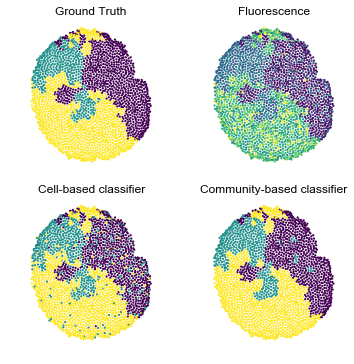

In [117]:
simulation_benchmark.show()

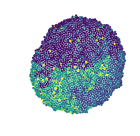

In [18]:
simulation_benchmark.plot_measurements(s=5)

In [146]:
batch_benchmark.logratio = True
simulation_benchmark = batch_benchmark.benchmark_simulation(0)
scores, df, labels = katz_annotation(simulation_benchmark.annotator, alpha=0.9)

print('INFOMAP:', simulation_benchmark.community_MAE)
print('KATZ:', scores.MAE)

INFOMAP: 0.015196544503706439
KATZ: 0.009694592946973647


In [147]:
import networkx as nx
from copy import deepcopy
from clones.validation.scoring import Scoring


def katz_annotation(annotator, alpha=0.9, beta=1.):
    """
    Katz centrality applied to undirected edges weighted by node similarity.
    """

    # build undirected graph weighted by node similarity
    G = nx.Graph()
    G.add_weighted_edges_from(annotator.graph.build_links())
    degree = np.vectorize(G.degree)(G.nodes)

    graph_df = annotator.graph.df.loc[list(G.nodes)]

    ground_truth_genotype = graph_df.ground.values
    node_posterior = annotator.cell_classifier.evaluate_posterior(graph_df)
    posterior = deepcopy(node_posterior.T)
    previous_genotype = posterior.argmax(axis=0)

    adjacency = nx.to_numpy_array(G)
    adjacency /= adjacency.sum(axis=0)

    n = np.array(adjacency).shape[0]
    centrality = np.linalg.solve(np.eye(n, n)-(alpha*adjacency), beta*posterior.T)

    new_genotypes = centrality.argmax(axis=1)

    new_scores = Scoring(ground_truth_genotype, new_genotypes)

    return new_scores, graph_df, new_genotypes

NameError: name 'ErrorColorbar' is not defined

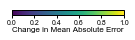

In [19]:
from growth.visualization.colorbars import ColorBar, ErrorColorBar
cbar = ColorBar(label='Change in Mean Absolute Error')
ebar = ErrorColorbar(vlim=(-8, 8), label='Fold-change in Mean Absolute Error')

In [54]:
p = np.arange(30).reshape(10, 3)

In [52]:
A = np.arange(100).reshape(10, 10)/100
B = np.ones(10)